In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load training data and plot it

Note how the data is loaded with `train = True`. You can load the test data in a similar fashion, just set `train = False`. Feel free to reuse my plot function!

cuda:0


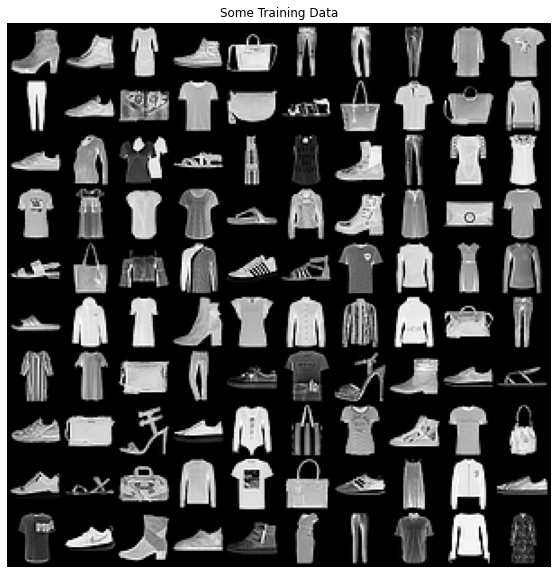

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 100
train_data = FashionMNIST("./data", train = True, download = True,
                          transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)

width = 28
height = 28
input_size = width * height

def plot_images(batch, rows, cols, title = ""):
    plt.figure(figsize = (rows, cols))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(
        vutils.make_grid(batch[:(rows * cols)], nrow = rows, normalize = True).cpu(),
        (1, 2, 0)))

first_batch = next(iter(train_loader))
plot_images(first_batch[0], 10, 10, "Some Training Data")

## Augmented Data
Here we are going to augment our training data to include random rotations and translations of the FashionMNIST images.

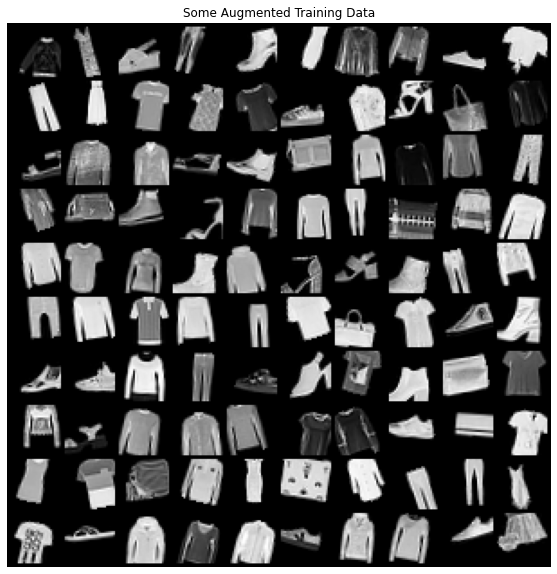

In [3]:
augment_transform = transforms.Compose([transforms.RandomAffine(degrees = 20, translate = (0.2, 0.2),
                                                                interpolation = transforms.InterpolationMode.BILINEAR),
                                        transforms.ToTensor()])

aug_train_data = FashionMNIST("./data", train = True, download = True,
                              transform=augment_transform)
aug_train_loader = DataLoader(aug_train_data, batch_size = batch_size, shuffle = True)

first_batch = next(iter(aug_train_loader))
plot_images(first_batch[0], 10, 10, "Some Augmented Training Data")

## Define Models

In [4]:
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, out_size):
        super(FullyConnectedAutoencoder, self).__init__()
        self.elayer1 = nn.Linear(input_size, 256)
        self.ebatch1 = nn.BatchNorm1d(256)
        self.elayer2 = nn.Linear(256, 128)
        self.ebatch2 = nn.BatchNorm1d(128)
        self.elayer3 = nn.Linear(128, out_size)

        self.dlayer1 = nn.Linear(out_size, 128)
        self.dbatch1 = nn.BatchNorm1d(128)
        self.dlayer2 = nn.Linear(128, 256)
        self.dbatch2 = nn.BatchNorm1d(256)
        self.dlayer3 = nn.Linear(256, input_size)
    
    def encoder(self, x):
        y1 = F.elu(self.ebatch1(self.elayer1(x)))
        y2 = F.elu(self.ebatch2(self.elayer2(y1)))
        z = F.elu(self.elayer3(y2))
        return z

    def decoder(self, z):
        y1 = F.elu(self.dbatch1(self.dlayer1(z)))
        y2 = F.elu(self.dbatch2(self.dlayer2(y1)))
        x = torch.sigmoid(self.dlayer3(y2))
        return x
        
    def forward(self, x):
        x = x.view(-1, input_size)
        z = self.encoder(x)
        y = self.decoder(z)
        y = y.view(-1, 1, width, height)
        return y

class ConvolutionalAutoencoder(nn.Module):
    def __init__(self, out_size):
        super(ConvolutionalAutoencoder, self).__init__()
        self.econv1 = nn.Conv2d(1, 32, kernel_size = 5, bias = False)
        self.ebatch1 = nn.BatchNorm2d(32)
        self.econv2 = nn.Conv2d(32, 8, kernel_size = 5, bias = False)
        self.ebatch2 = nn.BatchNorm2d(8)
        self.econv3 = nn.Conv2d(8, out_size, kernel_size = 20, bias = True)

        self.dconv1 = nn.ConvTranspose2d(out_size, 8, kernel_size = 20, bias = True)
        self.dbatch1 = nn.BatchNorm2d(8)
        self.dconv2 = nn.ConvTranspose2d(8, 32, kernel_size = 5, bias = False)
        self.dbatch2 = nn.BatchNorm2d(32)
        self.dconv3 = nn.ConvTranspose2d(32, 1, kernel_size = 5, bias = False)

    def encoder(self, x):
        y1 = F.elu(self.ebatch1(self.econv1(x)))
        y2 = F.elu(self.ebatch2(self.econv2(y1)))
        z = F.elu(self.econv3(y2))
        return z

    def decoder(self, z):
        y1 = F.elu(self.dbatch1(self.dconv1(z)))
        y2 = F.elu(self.dbatch2(self.dconv2(y1)))
        x = torch.sigmoid(self.dconv3(y2))
        return x
     
    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

## Train Models

The rest of the code below trains the models. Do not include this code in your solution and don't run it! (it takes forever without a GPU) Instead load the pre-trained models from the course website. This is included in case you want to see how I trained the models, and if you want to play with them beyond what is required.

In [5]:
def train(autoencoder, data_loader, num_epochs = 20, learn_rate = 0.5, weight_decay = 0.0):
    optimizer = torch.optim.SGD(autoencoder.parameters(), lr = learn_rate, weight_decay = weight_decay)
    mse_loss = nn.MSELoss()

    for epoch in range(num_epochs):
        tot_loss = 0
        for i, (x, label) in enumerate(data_loader):
            x = x.to(device)
            y = autoencoder(x)

            loss = mse_loss(x, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tot_loss = tot_loss + loss.data.cpu().numpy()

        print(epoch, ": Loss =", tot_loss)
        
    return autoencoder

In [6]:
fcAE16 = FullyConnectedAutoencoder(16)
fcAE16 = train(fcAE16.to(device), train_loader)
torch.save(fcAE16.state_dict(), "fcAE16.pth")

0 : Loss = 63.467875227332115
1 : Loss = 29.426955711096525
2 : Loss = 20.94723184220493
3 : Loss = 18.079743230715394
4 : Loss = 16.541576774790883
5 : Loss = 15.501672899350524
6 : Loss = 14.770922565832734
7 : Loss = 14.187902115285397
8 : Loss = 13.70486405491829
9 : Loss = 13.318530173972249
10 : Loss = 12.994033893570304
11 : Loss = 12.702255699783564
12 : Loss = 12.48595666512847
13 : Loss = 12.246654015034437
14 : Loss = 12.071185175329447
15 : Loss = 11.915328977629542
16 : Loss = 11.753389062359929
17 : Loss = 11.63798845000565
18 : Loss = 11.5035489089787
19 : Loss = 11.383306108415127


In [7]:
fcAE32 = FullyConnectedAutoencoder(32)
fcAE32 = train(fcAE32.to(device), train_loader)
torch.save(fcAE32.state_dict(), "fcAE32.pth")

0 : Loss = 63.71249134838581
1 : Loss = 29.577632054686546
2 : Loss = 20.836554545909166
3 : Loss = 17.797858010977507
4 : Loss = 16.165638646110892
5 : Loss = 15.079469542950392
6 : Loss = 14.264912759885192
7 : Loss = 13.625683294609189
8 : Loss = 13.094525450840592
9 : Loss = 12.64571605809033
10 : Loss = 12.253815796226263
11 : Loss = 11.923334989696741
12 : Loss = 11.607364557683468
13 : Loss = 11.349023189395666
14 : Loss = 11.099765984341502
15 : Loss = 10.866884355433285
16 : Loss = 10.649634456261992
17 : Loss = 10.488845004700124
18 : Loss = 10.305387256667018
19 : Loss = 10.12044018600136


In [8]:
fcAE128 = FullyConnectedAutoencoder(128)
fcAE128 = train(fcAE128.to(device), train_loader)
torch.save(fcAE128.state_dict(), "fcAE128.pth")

0 : Loss = 63.68454249948263
1 : Loss = 29.002349715679884
2 : Loss = 20.200024718418717
3 : Loss = 17.247442167252302
4 : Loss = 15.603106992319226
5 : Loss = 14.492722736671567
6 : Loss = 13.674531757831573
7 : Loss = 13.015829432755709
8 : Loss = 12.42947843298316
9 : Loss = 11.981229346245527
10 : Loss = 11.555414997041225
11 : Loss = 11.194687494076788
12 : Loss = 10.869789779186249
13 : Loss = 10.596894537098706
14 : Loss = 10.32939837500453
15 : Loss = 10.084798251278698
16 : Loss = 9.86124489735812
17 : Loss = 9.66110507491976
18 : Loss = 9.47360023483634
19 : Loss = 9.298107991926372


In [9]:
convAE16 = ConvolutionalAutoencoder(16)
convAE16 = train(convAE16.to(device), train_loader)
torch.save(convAE16.state_dict(), "convAE16.pth")

0 : Loss = 17.729797925800085
1 : Loss = 11.631484484300017
2 : Loss = 10.590197233483195
3 : Loss = 10.005732081830502
4 : Loss = 9.627376860007644
5 : Loss = 9.344771049916744
6 : Loss = 9.122983755543828
7 : Loss = 8.924591205082834
8 : Loss = 8.818984483368695
9 : Loss = 8.669636325910687
10 : Loss = 8.531206410378218
11 : Loss = 8.406534072943032
12 : Loss = 8.325632826425135
13 : Loss = 8.245768739841878
14 : Loss = 8.142809647135437
15 : Loss = 8.085729765705764
16 : Loss = 8.067494491115212
17 : Loss = 7.949743477627635
18 : Loss = 7.911162819713354
19 : Loss = 7.840939690358937


In [10]:
convAE32 = ConvolutionalAutoencoder(32)
convAE32 = train(convAE32.to(device), train_loader)
torch.save(convAE32.state_dict(), "convAE32.pth")

0 : Loss = 16.685841456986964
1 : Loss = 9.833367240615189
2 : Loss = 8.606378674507141
3 : Loss = 7.9733362421393394
4 : Loss = 7.560850285924971
5 : Loss = 7.280288901180029
6 : Loss = 7.076791434548795
7 : Loss = 6.91986898612231
8 : Loss = 6.741994741372764
9 : Loss = 6.612986408174038
10 : Loss = 6.516579946503043
11 : Loss = 6.4375293627381325
12 : Loss = 6.341728669591248
13 : Loss = 6.241880906745791
14 : Loss = 6.184153090231121
15 : Loss = 6.127446543425322
16 : Loss = 6.076345006003976
17 : Loss = 6.024190594442189
18 : Loss = 5.969625157304108
19 : Loss = 5.906476436182857


In [12]:
convAE128 = ConvolutionalAutoencoder(128)
convAE128 = train(convAE128.to(device), train_loader)
torch.save(convAE128.state_dict(), "convAE128.pth")

0 : Loss = 13.960333668626845
1 : Loss = 7.178374862298369
2 : Loss = 5.9726465521380305
3 : Loss = 5.339568153489381
4 : Loss = 4.904838898219168
5 : Loss = 4.620344530325383
6 : Loss = 4.36775960912928
7 : Loss = 4.227314247749746
8 : Loss = 4.05731936218217
9 : Loss = 3.9467124161310494
10 : Loss = 3.803837487474084
11 : Loss = 3.727219652850181
12 : Loss = 3.6531148734502494
13 : Loss = 3.569298562128097
14 : Loss = 3.5016814819537103
15 : Loss = 3.451681116130203
16 : Loss = 3.401399211026728
17 : Loss = 3.359323556534946
18 : Loss = 3.317676188889891
19 : Loss = 3.270562832709402


## Augmented Training

In [13]:
convAE32 = ConvolutionalAutoencoder(32)
convAE32 = train(convAE32.to(device), aug_train_loader)
torch.save(convAE32.state_dict(), "convAE32_aug.pth")

0 : Loss = 16.797467866912484
1 : Loss = 9.402457392774522
2 : Loss = 8.071037956513464
3 : Loss = 7.4997064881026745
4 : Loss = 7.094058250077069
5 : Loss = 6.880816376768053
6 : Loss = 6.640550340525806
7 : Loss = 6.497330847196281
8 : Loss = 6.358714004978538
9 : Loss = 6.263871545903385
10 : Loss = 6.1839318023994565
11 : Loss = 6.060346473939717
12 : Loss = 5.973676720634103
13 : Loss = 5.9287839736789465
14 : Loss = 5.844487126916647
15 : Loss = 5.7785453563556075
16 : Loss = 5.733927176333964
17 : Loss = 5.703577301464975
18 : Loss = 5.63338197953999
19 : Loss = 5.6051118820905685
